In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../Zeolites/code/")
sys.path.insert(0, "../Zeolites/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt


from models.equivariant_mpnn import MPNN, MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

import tueplots 

from models.megnet import MEGNet
from models.cgcnn import CGCNN
from models.schnet import SchNet

In [2]:
import matplotlib as mpl


In [3]:
plt.rc('font', family='serif',)
#mpl.rc('text', usetex=True)

In [4]:
from tueplots import bundles

In [5]:
from matplotlib import rc


In [6]:
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

In [7]:
data = get_zeolite('MOR')
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l)

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [8]:
atoms.shape[0]

4123

In [9]:
title_size=7.5
label_size=7

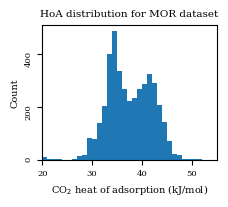

In [10]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(20,55,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for MOR dataset', fontsize=title_size)
plt.xlim(20,55)
plt.savefig('figures/datadist.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

0 Al atom, count: 1
1 Al atom, count: 48
2 Al atom, count: 150
3 Al atom, count: 330
4 Al atom, count: 525
5 Al atom, count: 405
6 Al atom, count: 405
7 Al atom, count: 375
8 Al atom, count: 405
9 Al atom, count: 410
10 Al atom, count: 390
11 Al atom, count: 334
12 Al atom, count: 345


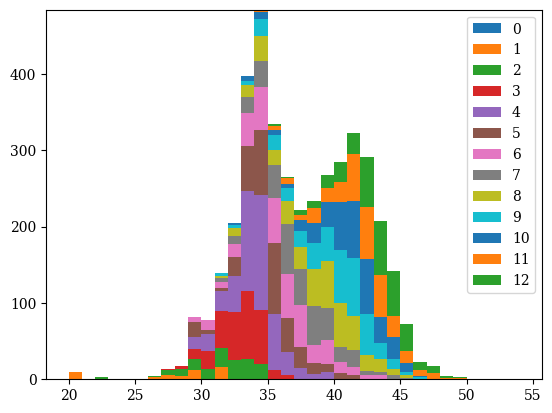

In [12]:
bins = np.arange(20,55,1)
bottom = np.zeros(bins.shape[0]-1)

locs = np.arange(20.5,54.5,1)



# for boolean, weight_count in weight_counts.items():
#     p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
#     bottom += weight_count

for i in np.unique(atoms.sum(1)):
    hist = np.histogram(hoa[atoms.sum(1) == i], bins=bins)[0]
    
    plt.bar(locs, hist, width=1, label=i, bottom=bottom)
    
    bottom += hist

    print(f'{i} Al atom, count: {(atoms.sum(1)==i).sum()}')
plt.legend()
    

In [13]:
hoa_x = np.tile(np.linspace(20,55,35)[:,None], (1,13))
hoa_y = np.tile(np.arange(0,13,1)[None], (hoa_x.shape[0],1))

In [14]:
hoa_x.shape, hoa_y.shape

((35, 13), (35, 13))

In [15]:
hoa.min()

20.7164

In [16]:
zi = np.zeros((len(hoa_x),13))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum()
              
    for _x in range(0,len(hoa_x)-1):
        
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            zi[_x, n_als] += 1

In [17]:
zi.sum(0)

array([  1.,  48., 150., 330., 525., 405., 405., 375., 405., 410., 390.,
       334., 345.])

In [18]:
zi = zi/zi.sum(0)[None]

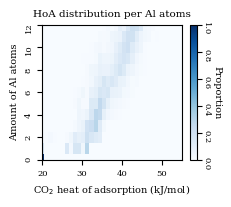

In [19]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')
#plt.colorbar()
plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0,14,2), np.arange(0,14,2), fontsize=6, rotation='vertical')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(20,55)
plt.ylim(0,12)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist.pdf', dpi=1200, bbox_inches="tight")

In [20]:
#help(plt.pcolormesh)

In [21]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, sub_lim=12)
_, testloader2, trainloader2 = get_data_graph(atoms, hoa, edges, bs=32, sub_lim=12)
_, testloader3, trainloader3 = get_data_megnet(atoms, hoa, edges, bs=32, sub_lim=12)

In [22]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum').to('cuda')

mpnn2 = MPNN(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, ref, tra,
                        hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                        centers=10, mx_d=6, width=1, pool='sum').to('cuda')
meg = MEGNet(idx1, idx2).cuda()

sch = SchNet(d).cuda()

cgcnn = CGCNN(idx1, idx2).cuda()

In [23]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [24]:
props = [0.125, .25, .5, .75, 1.]
names = ['pore','equi']

mae_p = []
mse_p = []


mae_e = []
mse_e = []

mae_p_ci = []
mse_p_ci = []


mae_e_ci = []
mse_e_ci = []


mae_s = []
mse_s = []

mae_s_ci = []
mse_s_ci = []


for i in props:
    
    _mae_p = []
    _mse_p = []
    _mae_e = []
    _mse_e = []
    _mae_s = []
    _mse_s = []
    
    for j in range(1,11):
    
        mpnn.load_state_dict(torch.load(f'model_data/{i}/pore/model_{j}/model.pth'))
        y_pred, y_true = mpnn.predict(testloader)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_p.append(_mae)
        _mse_p.append(_mse)

        mpnn2.load_state_dict(torch.load(f'model_data/{i}/equi/model_{j}/model.pth'))
        y_pred, y_true = mpnn2.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_e.append(_mae)
        _mse_e.append(_mse)
    
    
        sch.load_state_dict(torch.load(f'model_data/{i}/schnet/model_{j}/model.pth'))
        y_pred, y_true = sch.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_s.append(_mae)
        _mse_s.append(_mse)
    
    mae_p.append(np.mean(_mae_p))
    mse_p.append(np.mean(_mse_p))
    mae_e.append(np.mean(_mae_e))
    mse_e.append(np.mean(_mse_e))
    mae_s.append(np.mean(_mae_s))
    mse_s.append(np.mean(_mse_s))

    
    mae_p_ci.append(get_95_CI(_mae_p))
    mse_p_ci.append(get_95_CI(_mse_p))
    mae_e_ci.append(get_95_CI(_mae_e))
    mse_e_ci.append(get_95_CI(_mse_e))
    mae_s_ci.append(get_95_CI(_mae_s))
    mse_s_ci.append(get_95_CI(_mse_s))

    print(i)
    

0.125
0.25
0.5
0.75
1.0


In [25]:
mae_sch = []
mse_sch = []

mae_meg = []
mse_meg = []

mae_cg = []
mse_cg = []

for j in range(1,11):
    
    sch.load_state_dict(torch.load(f'model_data/1.0/schnet/model_{j}/model.pth'))

    y_pred, y_true = sch.predict(testloader2)
    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_sch.append(_mae)
    mse_sch.append(_mse)

    meg.load_state_dict(torch.load(f'model_data/1.0/megnet/model_{j}/model.pth'))
    y_pred, y_true = meg.predict(testloader3)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_meg.append(_mae)
    mse_meg.append(_mse)
    
    
    cgcnn.load_state_dict(torch.load(f'model_data/1.0/cgcnn/model_{j}/model.pth'))
    y_pred, y_true = cgcnn.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_cg.append(_mae)
    mse_cg.append(_mse)
    
    
    print(j)
    

1
2
3
4
5
6
7
8
9
10


In [26]:
maes = [mae_cg, mae_meg, mae_sch, _mae_e, _mae_p]
mses = [mse_cg, mse_meg, mse_sch, _mse_e, _mse_p]

In [27]:
df = pd.DataFrame(columns = ['MAE','MSE'], index=['CGCNN','MEGNet','SchNet','Ours (without pores)', 'Ours (with pores)'])
for i in range(len(df.index)):
    
    mu_a = np.mean(maes[i]).round(3)
    mu_s = np.mean(mses[i]).round(3)
    
    ci_a = get_95_CI(maes[i]).round(3)
    ci_s = get_95_CI(mses[i]).round(3)
    
    
    a = fr'{mu_a} $$\pm$$ {ci_a}'
    s = fr'{mu_s} $$\pm$$ {ci_s}'
    
    df.loc[df.index[i]] = [a,s]

In [28]:
print(df.to_latex(escape=False))

\begin{tabular}{lll}
\toprule
{} &                  MAE &                  MSE \\
\midrule
CGCNN                &  1.618 $$\pm$$ 0.112 &  4.511 $$\pm$$ 0.493 \\
MEGNet               &  1.397 $$\pm$$ 0.062 &  3.627 $$\pm$$ 0.241 \\
SchNet               &  1.123 $$\pm$$ 0.059 &  2.227 $$\pm$$ 0.189 \\
Ours (without pores) &  1.378 $$\pm$$ 0.136 &  3.158 $$\pm$$ 0.521 \\
Ours (with pores)    &  1.002 $$\pm$$ 0.032 &  1.742 $$\pm$$ 0.099 \\
\bottomrule
\end{tabular}



C:\Users\Marko\AppData\Local\Temp\ipykernel_12252\4079661275.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False))


In [29]:
np.mean(_mae_p), get_95_CI(_mae_p), np.mean(mae_sch), get_95_CI(mae_sch)

(1.0016526758670807,
 0.032368414045069516,
 1.1225712895393372,
 0.05879500680677597)

In [30]:
mae_p = np.array(mae_p)
mse_p = np.array(mse_p)
mae_e = np.array(mae_e)
mse_e = np.array(mse_e)
mae_s = np.array(mae_s)
mse_s = np.array(mse_s)

mae_p_ci = np.array(mae_p_ci)
mse_p_ci = np.array(mse_p_ci)
mae_e_ci = np.array(mae_e_ci)
mse_e_ci = np.array(mse_e_ci)
mae_s_ci = np.array(mae_s_ci)
mse_s_ci = np.array(mse_s_ci)

In [31]:
props2 = np.array(props)*len(trainloader.dataset)

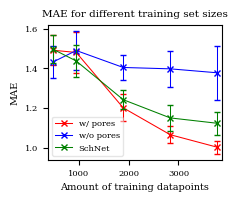

In [32]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mae_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_p, mae_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_p-mae_p_ci, mae_p+mae_p_ci, color='red', alpha=.3)
plt.plot(props2, mae_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_e, mae_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_e-mae_e_ci, mae_e+mae_e_ci, color='blue', alpha=.3)
plt.plot(props2, mae_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_s, mae_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_s-mae_s_ci, mae_s+mae_s_ci, color='green', alpha=.3)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MAE', fontsize=label_size)
plt.title('MAE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='lower left', framealpha=0.5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
plt.savefig('figures/mae2.pdf', dpi=1200, bbox_inches = "tight")
#plt.savefig('figures/mae2.eps', dpi=1200, bbox_inches = "tight");

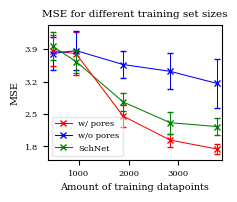

In [33]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mse_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_p, mse_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_p-mae_p_ci, mae_p+mae_p_ci, color='red', alpha=.3)
plt.plot(props2, mse_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_e, mse_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_e-mae_e_ci, mae_e+mae_e_ci, color='blue', alpha=.3)
plt.plot(props2, mse_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_s, mse_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_s-mae_s_ci, mae_s+mae_s_ci, color='green', alpha=.3)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MSE', fontsize=label_size)
plt.title('MSE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='lower left', framealpha=0.5)
plt.xticks(fontsize=6)
plt.yticks(np.arange(1.8,4.6,7/10), [1.8,2.5,3.2,3.9],fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
plt.savefig('figures/mse2.pdf', dpi=1200, bbox_inches = "tight")
#plt.savefig('figures/mse2.eps', dpi=1200, bbox_inches = "tight");

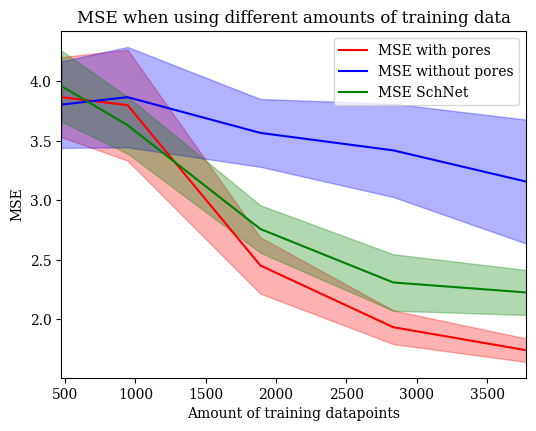

In [34]:
plt.figure(figsize=(6,4.5))
plt.plot(props2, mse_p, c='red', label = 'MSE with pores')
plt.fill_between(props2, mse_p-mse_p_ci, mse_p+mse_p_ci, color='red', alpha=.3)
plt.plot(props2, mse_e, c='blue', label = 'MSE without pores')
plt.fill_between(props2, mse_e-mse_e_ci, mse_e+mse_e_ci, color='blue', alpha=.3)
plt.plot(props2, mse_s, c='green', label = 'MSE SchNet')
plt.fill_between(props2, mse_s-mse_s_ci, mse_s+mse_s_ci, color='green', alpha=.3)

plt.xlabel('Amount of training datapoints')
plt.ylabel('MSE')
plt.title('MSE when using different amounts of training data')
plt.legend()
plt.xlim(props2.min(), props2.max())
plt.savefig('figures/mse.pdf', dpi=1200);

In [35]:
color = np.zeros((X.shape[0],))
for i in range(len(X)):
    
    for j in range(4):
        
        for k in range(ref.shape[0]):
            
            if np.abs(X[i] - (np.mod(ref[k]*X[j] + tra[k], 1))).sum() < 0.001:
                
                color[i] = j
                
                break
        

In [36]:
color2 = np.zeros((X_pore.shape[0],))
for i in range(len(X_pore)):
    
    for j in [0,2,4]:
        
        for k in range(ref.shape[0]):
            
            if np.abs(X_pore[i] - (np.mod(ref[k]*X_pore[j] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break

In [37]:
color2

array([0., 0., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4.])

In [38]:
ce_dict = {}
row, col = np.nonzero(A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [39]:
A_pore.shape, A_pore.sum()

((48, 12), 128)

In [40]:
cp_dict = {}
row, col = np.nonzero(A_pore)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X_pore[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [41]:
ce_dict.keys(), cp_dict.keys()

(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]))

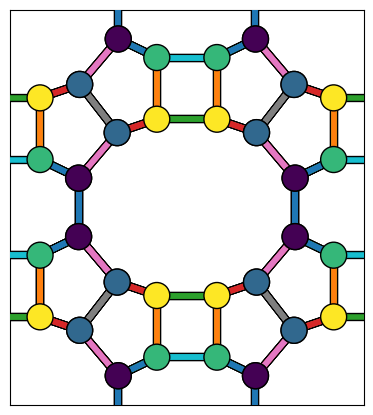

In [42]:
plt.figure(figsize=(18.256/4, 20.534/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
# for i in cp_dict:
#     x = 0
#     for j in cp_dict[i]:
        
#         x1, x2 = X[j[0]].copy(), X_pore[j[1]].copy()
        
#         d = x2-x1
        
#         for _d in range(3):
            
#             if d[_d] > 0.5:
                
#                 x2[_d] -= 1
            
#             elif d[_d] < -.5:
                
#                 x2[_d] += 1
            
        
        
        
#         if x == 0:
            
#             line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--')
        
#         plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--')
#         x+=1
        
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')
#plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
# plt.scatter(X_pore[:,0], X_pore[:,1], s=150, zorder=10, c=color2, marker='s')
# plt.scatter(X_pore[:,0]+1, X_pore[:,1], s=150, zorder=10, c=color2, marker='s')
# plt.scatter(X_pore[:,0], X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s')
# plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('figures/weight_sharing.svg', bbox_inches='tight', dpi=1200)
plt.savefig('figures/weight_sharing.pdf', bbox_inches='tight', dpi=1200);

In [43]:
l

array([18.256, 20.534,  7.542])

In [44]:
line[0].get_c()

'#d62728'

In [45]:
c

9

In [46]:
best_idx = np.argmin(_mae_p)
mpnn.load_state_dict(torch.load(f'model_data/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn.predict(testloader)

In [47]:
from scipy.interpolate import griddata

In [48]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(35.5746), tensor(48.1032), tensor(35.5141), tensor(51.0956))

In [49]:
Z = torch.ones_like(y_pred)

In [50]:
nn = 100
xmin = 34
xmax = 52
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [51]:
#xi.shape, yi.shape, xi, yi

In [52]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [53]:
zi.shape

(100, 100)

In [54]:
zi.argmax(axis=1)

array([ 0,  0,  0,  0,  0,  0,  0,  0, 17,  0, 15,  0,  0,  0,  0,  0,  0,
        0,  0,  8, 18, 27, 33,  0,  0, 17, 17,  0, 35, 24, 21, 30, 32, 42,
       27, 33, 57, 45, 30, 37, 39, 17, 48, 39, 45, 41, 41, 40, 48, 45, 54,
       47, 50, 49, 51, 52, 48, 53, 57, 53, 58, 58, 58, 58, 62, 61, 56, 53,
        0, 61, 56, 74, 63,  0,  0,  0, 61, 94,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

C:\Users\Marko\AppData\Local\Temp\ipykernel_12252\4168279679.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', 6)


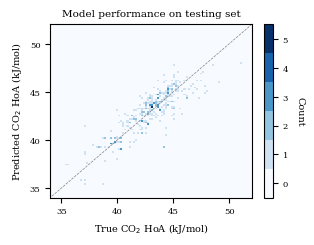

In [55]:
fig, ax = plt.subplots(figsize=(3.25,2.25))
cmap = plt.cm.get_cmap('Blues', 6)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Predicted CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(5/12., 5, 5/6), [0,1,2,3,4,5] )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

plt.savefig('figures/truepred.svg', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred.pdf', dpi=1200, bbox_inches="tight")

In [58]:
np.arange(5/12., 5, 5/6)

array([0.41666667, 1.25      , 2.08333333, 2.91666667, 3.75      ,
       4.58333333])

In [59]:
5/6

0.8333333333333334

In [60]:
yax = cbar.ax.get_yaxis()

In [61]:
yax.get_ticklocs()

array([0.41666667, 1.25      , 2.08333333, 2.91666667, 3.75      ,
       4.58333333])

In [62]:
np.arange(0.5, 5.5, 1)

array([0.5, 1.5, 2.5, 3.5, 4.5])

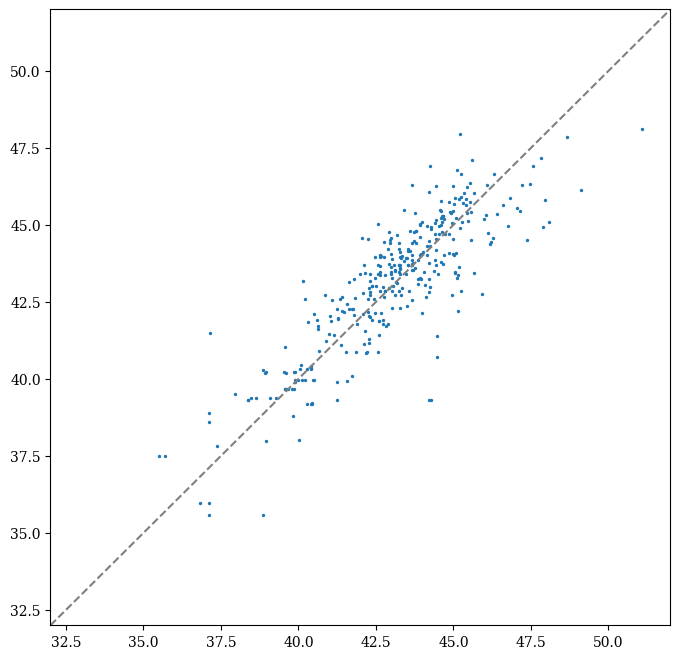

<Figure size 1000x1000 with 0 Axes>

In [63]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(y_true, y_pred, s=2)
plt.xlim(32,52)
plt.ylim(32,52)
plt.figure(figsize=(10,10))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5")

In [64]:
yy, xx = np.meshgrid(np.linspace(30, 55, 100), np.linspace(30, 55, 100))

yy.shape

(100, 100)

In [65]:
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

In [66]:
meg.load_state_dict(torch.load(f'model_data/1.0/megnet/model_1/model.pth'))
y_pred, y_true = meg.predict(testloader3)
_mse = ((y_pred - y_true)**2).mean().item()
_mae = (y_pred - y_true).abs().mean().item()

In [67]:
_mse, _mae

(3.7824950218200684, 1.4541676044464111)

In [477]:
class hoa_maximizer(nn.Module):
    
    def __init__(self, bonds, bonds_sp, bonds_ps, pores,atoms=torch.zeros(2,48,1).cuda()):
        
        super().__init__()
        
        self.bonds = bonds[None].repeat(atoms.shape[0], 1, 1).float().cuda()
        self.bonds_sp = bonds_sp[None].repeat(atoms.shape[0], 1, 1).float().cuda()
        self.bonds_ps = bonds_ps[None].repeat(atoms.shape[0], 1, 1).float().cuda()
        self.pores = pores[None].repeat(atoms.shape[0], 1, 1).float().cuda()
        
        self.bonds.requires_grad = False
        self.bonds_sp.requires_grad = False
        self.bonds_ps.requires_grad = False
        self.pores.requires_grad = False
        
        
        self.filter = nn.Hardtanh(0,1)
        
        self.atoms = nn.Parameter(atoms.float())
        
        self.cuda()
        
    def forward(self, opt, model, epoch = 0, print_int = 5, max_ats=12):
        
        self.train()
        
        opt.zero_grad()
        
        atoms1 = self.filter(self.atoms)
        
        atoms2 = atoms1.round()
        
        atoms_m = atoms2.sum((1,2)) > max_ats
        
        if atoms_m.sum() > 0:
            
            zeros = torch.zeros((atoms2[atoms_m].shape[0], 48, 1)).cuda()
            idx = torch.topk(atoms2[atoms_m], max_ats, 1)[1]
            zeros = zeros.scatter_(1, idx, 1.0)
            atoms2[atoms_m] = zeros
        
        atoms3 = atoms2 - self.atoms.detach() + self.atoms
        
        y_hat = model(atoms3, self.bonds, self.pores, self.bonds_sp, self.bonds_ps)
        
        #ats_sum = (50*(atoms3.sum((1,2)) - 12))**2
        
        #(-y_hat.mean()+ats_sum.mean()).backward(retain_graph=True)
        
        (-y_hat.mean()).backward(retain_graph=True)
        opt.step()
        
        _atoms = self.atoms.data.clamp(0.,1.)
        self.atoms.data = _atoms
        
        self.eval()
        with torch.no_grad():
            
            atoms2 = self.filter(self.atoms).round()
        
            atoms_m = atoms2.sum((1,2)) > max_ats

            if atoms_m.sum() > 0:

                zeros = torch.zeros((atoms2[atoms_m].shape[0], 48, 1)).cuda()
                idx = torch.topk(atoms2[atoms_m], max_ats, 1)[1]
                zeros = zeros.scatter_(1, idx, 1.0)
                atoms2[atoms_m] = zeros
            
            
            
            y_hat = model(atoms2, self.bonds, self.pores, self.bonds_sp, self.bonds_ps)
        
        if (epoch + 1) % print_int == 0:
            print(f'epoch {epoch+1:2} hoa: {y_hat.mean().item()}')
        
        
        return y_hat
      
        
    
    def optimize(self, model, epochs=100, print_int=10, max_ats=12):
        
        optimizer = optim.Adam(self.parameters(), lr=0.005)
        
        model.requires_grad = False
        
        y_hats = np.zeros((epochs+1, self.atoms.shape[0]))
        
        with torch.no_grad():
            y_hat = model.forward(self.atoms.round(), self.bonds, self.pores, self.bonds_sp, self.bonds_ps)
            y_hats[0] = y_hat.clone().cpu().numpy()[:,0]
        
        for i in range(epochs):
            
            y_hat = self.forward(optimizer, model, i, print_int, max_ats)
            
            y_hats[i+1] = y_hat.clone().cpu().numpy()[:,0]
            
        atoms2 = self.filter(self.atoms.data).round()
        
        atoms_m = atoms2.sum((1,2)) > max_ats

        if atoms_m.sum() > 0:

            zeros = torch.zeros((atoms2[atoms_m].shape[0], 48, 1)).cuda()
            idx = torch.topk(atoms2[atoms_m], max_ats, 1)[1]
            zeros = zeros.scatter_(1, idx, 1.0)
            atoms2[atoms_m] = zeros
        
        return atoms2, y_hats

In [478]:
opt_dict = {}

In [488]:
n = 16
epochs = 200
for i in range(6,18):
    
    ats = torch.zeros((n,48,1))
    y_hats = torch.zeros((epochs+1, n))
    
    ats0= torch.rand((n,48,1))
    
    pr = i*1/96 
    
    ats1 = torch.where(ats0 < pr, .9, .1)
    print('avg number of starting Als', ats1.round().sum((1,2)).float().mean().item())
    
    for j in range(int(n/2)):
    
        h_max = hoa_maximizer(edges, edges_sp, edges_ps, torch.tensor(pore), atoms=ats1[2*j:2*(j+1)].float().cuda())
        _ats, _y_hats = h_max.optimize(mpnn, epochs, 50, i)
        
        ats[2*j:2*(j+1)] = _ats
        y_hats[:, 2*j:2*(j+1)] = torch.tensor(_y_hats)

    print('avg number of sub Als', ats.round().sum((1,2)).mean().item(), 'expected Als', i)
    
    opt_dict[i] = [ats, y_hats]

avg number of starting Als 3.5
epoch 50 hoa: 34.5784797668457
epoch 100 hoa: 33.38103485107422
epoch 150 hoa: 34.747100830078125
epoch 200 hoa: 39.35572814941406
epoch 50 hoa: 34.874290466308594
epoch 100 hoa: 38.30986404418945
epoch 150 hoa: 40.11918640136719
epoch 200 hoa: 40.11918640136719
epoch 50 hoa: 34.89177703857422
epoch 100 hoa: 36.791900634765625
epoch 150 hoa: 36.791900634765625
epoch 200 hoa: 37.26873016357422
epoch 50 hoa: 32.615501403808594
epoch 100 hoa: 37.86260223388672
epoch 150 hoa: 38.16989517211914
epoch 200 hoa: 39.699459075927734
epoch 50 hoa: 35.26380920410156
epoch 100 hoa: 36.43418884277344
epoch 150 hoa: 39.06488037109375
epoch 200 hoa: 39.13382339477539
epoch 50 hoa: 33.85039138793945
epoch 100 hoa: 37.83848571777344
epoch 150 hoa: 38.78731918334961
epoch 200 hoa: 38.16286087036133
epoch 50 hoa: 30.16740608215332
epoch 100 hoa: 30.087465286254883
epoch 150 hoa: 30.087465286254883
epoch 200 hoa: 30.08746337890625
epoch 50 hoa: 29.701702117919922
epoch 100 ho

In [489]:
for i in opt_dict:
    
    print(opt_dict[i][1].max())

tensor(43.1413)
tensor(42.7871)
tensor(46.9894)
tensor(47.0900)
tensor(47.1067)
tensor(47.5952)
tensor(49.5412)
tensor(48.9172)
tensor(50.4127)
tensor(50.5359)
tensor(53.1147)
tensor(53.9814)


In [335]:
ats0= torch.rand((2,48,1))
ats1 = torch.where(ats0 < .1, 1, 0)
print(ats1.sum((1,2)))

tensor([6, 5])


In [336]:
h_max = hoa_maximizer(edges, edges_sp, edges_ps, torch.tensor(pore), atoms=ats1.float().cuda())

In [337]:
h_max.atoms.shape

torch.Size([2, 48, 1])

In [338]:
ats, y_hats = h_max.optimize(mpnn, 125, 5)

epoch  5 hoa: 37.29650115966797
epoch 10 hoa: 37.29650115966797
epoch 15 hoa: 37.29650115966797
epoch 20 hoa: 37.29650115966797
epoch 25 hoa: 37.29650115966797
epoch 30 hoa: 37.29650115966797
epoch 35 hoa: 37.29650115966797
epoch 40 hoa: 37.29650115966797
epoch 45 hoa: 37.29650115966797
epoch 50 hoa: 37.29650115966797
epoch 55 hoa: 49.32270812988281
epoch 60 hoa: 45.44495391845703
epoch 65 hoa: 46.43492889404297
epoch 70 hoa: 47.11254119873047
epoch 75 hoa: 48.36158752441406
epoch 80 hoa: 49.462223052978516
epoch 85 hoa: 48.36158752441406
epoch 90 hoa: 47.5235595703125
epoch 95 hoa: 49.462223052978516
epoch 100 hoa: 48.01655578613281
epoch 105 hoa: 48.854591369628906
epoch 110 hoa: 48.62419128417969
epoch 115 hoa: 48.854591369628906
epoch 120 hoa: 49.622474670410156
epoch 125 hoa: 49.01483917236328


In [339]:
ats[0].sum()

tensor(9.2023, device='cuda:0')

(0.0, 100.0)

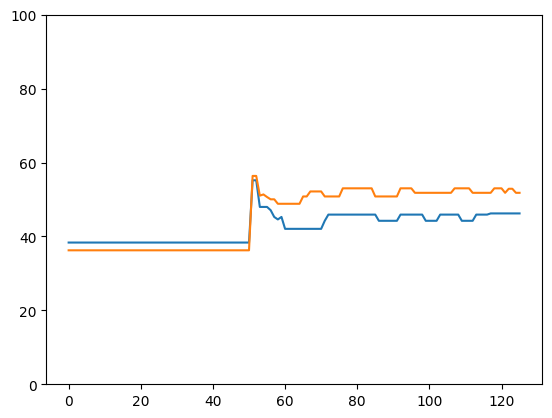

In [340]:
for i in range(y_hats.shape[1]):
    
    plt.plot(y_hats[:,i])

plt.ylim(0,100)

In [341]:
testloader.dataset.y.amax()

tensor(51.0956, dtype=torch.float64)